# Constructing linear models of firing rates with respect to velocity and duration

In [52]:
%load_ext autoreload
%autoreload 2

import numpy as np
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load data

In [53]:

# here load rate_cat using numpy.load with allow_pickle=True
path_data = '../../data/processed'
date_data = '20250529'
spike_cat = np.load(f'{path_data}/spike_cat_{date_data}.npz', allow_pickle=True)['spike_cat']
vel_cat = np.load(f'{path_data}/vel_cat_{date_data}.npz', allow_pickle=True)['vel_cat']
dur_cat = np.load(f'{path_data}/dur_cat_{date_data}.npz', allow_pickle=True)['dur_cat']

In [54]:

rate_cat = []
for spike1 in spike_cat:
    rate1 = []
    for spike1_per_angle in spike1:
        # filter spike1_per_angle with gaussian_filter1d
        rate2 = 1e3*gaussian_filter1d(spike1_per_angle.astype(float), sigma=6, axis=1)
        rate1.append(rate2[:,50:-50])
    rate_cat.append(rate1)

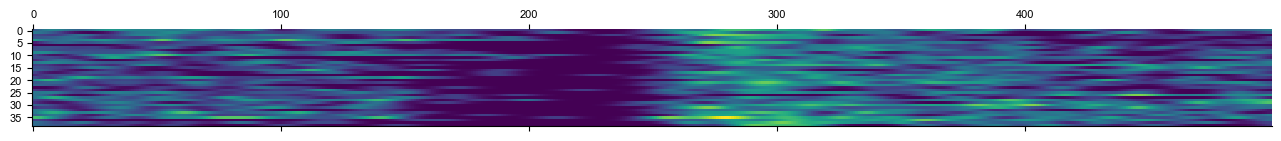

In [55]:
plt.matshow(rate_cat[0][0])

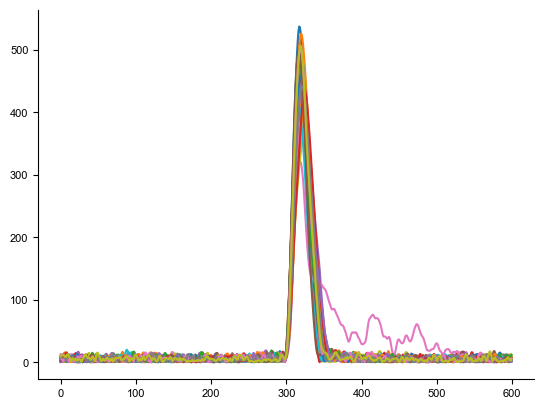

In [56]:
plt.plot(vel_cat[0][0].T);

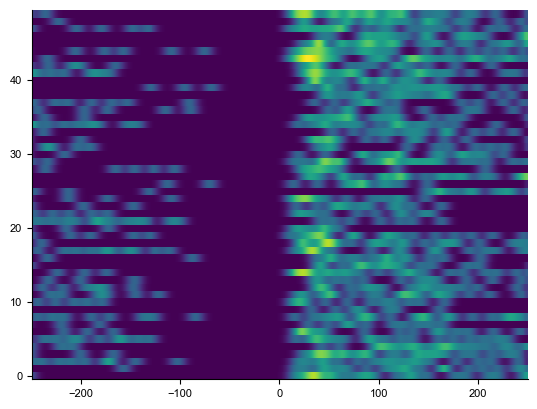

In [57]:
tt = np.arange(-249, 251)
direction = 1
cell = 1
plt.pcolor(tt, np.arange(rate_cat[cell][direction].shape[0]), rate_cat[cell][direction])
plt.show()

In [58]:
pv_cat = []
for a in range(np.shape(vel_cat)[0]):
    M = []
    for ori in range(8):
        temp = vel_cat[a][ori]
        M.append(np.max(temp,axis = 1)*1e-3)
        # pv_cat[a][ori]  = np.max(temp,axis = 1)
    pv_cat.append(M)

pv_cat = np.array(pv_cat, dtype = object)

In [59]:
pv_cat[cell][direction]

array([0.38071803, 0.41812638, 0.39505224, 0.39936837, 0.27699616,
       0.38138656, 0.39918563, 0.36982533, 0.38486361, 0.3705016 ,
       0.41378384, 0.34945198, 0.35057682, 0.32834053, 0.37510678,
       0.33003098, 0.35105566, 0.38356764, 0.39464443, 0.39497115,
       0.47773801, 0.34526822, 0.44058711, 0.34041444, 0.40480857,
       0.23269177, 0.46256277, 0.42881097, 0.35591657, 0.34976399,
       0.39066948, 0.30568819, 0.37472308, 0.33895274, 0.32159746,
       0.42856125, 0.28356135, 0.33665252, 0.27171929, 0.34186503,
       0.39558377, 0.42627107, 0.39964298, 0.47456307, 0.41151626,
       0.46260527, 0.34771883, 0.39238949, 0.40345278, 0.38167419])

### Here we compute the statistics of kinematic parameters

First we collect all the kinematic parameters (peak velocity, average velocity = 10/duration) from all the data sets.

In [60]:
pv_all = np.empty(0)
for session in pv_cat:
    for ori in session:
        pv_all = np.hstack((pv_all, ori))

av_all = np.empty(0)
for session in dur_cat:
    for dur in session[:8]:
        av_all = np.hstack((av_all, 10/dur))

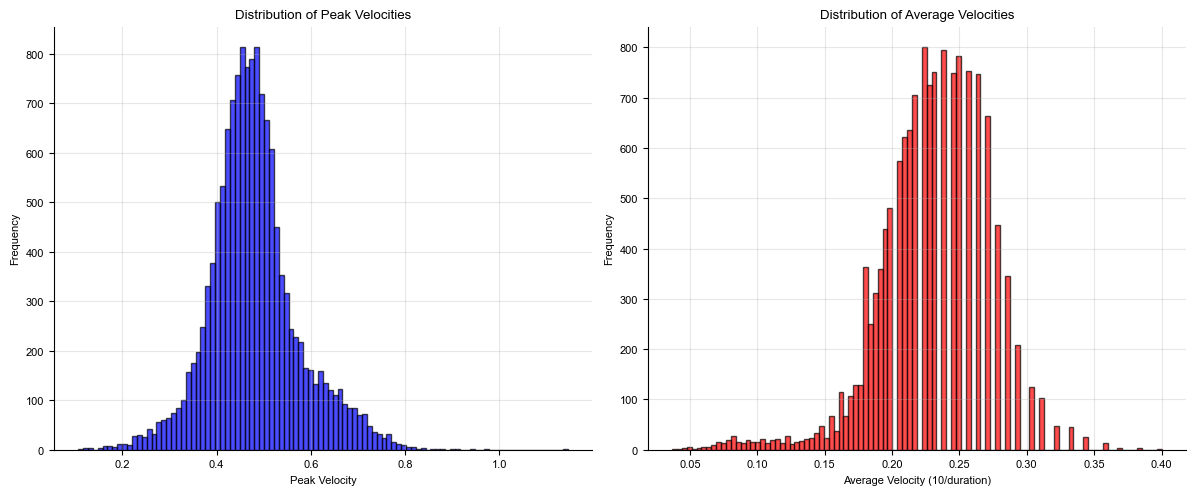

Peak Velocity: 0.47885947 ± 0.09520212
Average Velocity: 0.22651465 ± 0.04065501


In [61]:
# plot the histogram of pv_all and av_all side by side
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot histogram of peak velocities
ax1.hist(pv_all, bins=100, alpha=0.7, color='blue', edgecolor='black')
ax1.set_xlabel('Peak Velocity')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of Peak Velocities')
ax1.grid(True, alpha=0.3)

# Plot histogram of average velocities
ax2.hist(av_all, bins=100, alpha=0.7, color='red', edgecolor='black')
ax2.set_xlabel('Average Velocity (10/duration)')
ax2.set_ylabel('Frequency')
ax2.set_title('Distribution of Average Velocities')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

pv0 = np.nanmean(pv_all)
av0 = np.nanmean(av_all)

sd_pv = np.std(pv_all)
sd_av = np.std(av_all)

# print all the statistics of pv_all and av_all mean+-sd form
print(f"Peak Velocity: {pv0:.8f} ± {sd_pv:.8f}")
print(f"Average Velocity: {av0:.8f} ± {sd_av:.8f}")



In [62]:
print(0.47885947 +  0.09520212*1.5)
print(0.47885947 -  0.09520212*1.5)

0.62166265
0.33605629000000004


In [63]:
from sklearn.linear_model import LinearRegression

def create_av_pv_model(pv_all, av_all, pv_center=0.48, pv_range=0.1):
    """
    Create a linear model to predict AV based on PV with constrained data range.

    Parameters:
    - pv_all: Array of all peak velocity values
    - av_all: Array of all average velocity values
    - pv_center: Center value for PV range constraint (default: 0.48)
    - pv_range: Range around center to include (default: 0.1)

    Returns:
    - model: Fitted linear regression model
    - slope: Linear relationship slope
    - intercept: Linear relationship intercept
    - r_squared: Model performance metric
    """

    # Define the constrained range for PV
    pv_min = pv_center - pv_range  # 0.48 - 0.1 = 0.38
    pv_max = pv_center + pv_range  # 0.48 + 0.1 = 0.58

    # Filter data to only include values within the specified PV range
    mask = (pv_all >= pv_min) & (pv_all <= pv_max)
    pv_filtered = pv_all[mask]
    av_filtered = av_all[mask]

    # Remove any NaN values
    valid_mask = ~(np.isnan(pv_filtered) | np.isnan(av_filtered))
    pv_clean = pv_filtered[valid_mask]
    av_clean = av_filtered[valid_mask]

    print(f"Using {len(pv_clean)} data points from range [{pv_min:.2f}, {pv_max:.2f}]")
    print(f"Original dataset size: {len(pv_all)}")

    # Fit linear regression model
    model = LinearRegression()
    X = pv_clean.reshape(-1, 1)  # Reshape for sklearn
    y = av_clean

    model.fit(X, y)

    # Get model parameters
    slope = model.coef_[0]
    intercept = model.intercept_
    r_squared = model.score(X, y)

    print(f"Linear relationship: AV = {slope:.6f} * PV + {intercept:.6f}")
    print(f"R-squared: {r_squared:.6f}")

    return model, slope, intercept, r_squared

def predict_av_from_pv(pv, model):
    """
    Predict AV given PV based on the linear relationship.

    Parameters:
    - pv: Peak velocity value(s) to predict for
    - model

    Returns:
    - av_predicted: Predicted average velocity value(s)
    """
    av_predicted = model.coef_[0] * pv + model.intercept_
    return av_predicted

def dur_from_pv(pv, model):
    return 10/predict_av_from_pv(pv, model)

model_av, _, _, _ = create_av_pv_model(pv_all, av_all, pv_range=0.15)



Using 12357 data points from range [0.33, 0.63]
Original dataset size: 14031
Linear relationship: AV = 0.332865 * PV + 0.071015
R-squared: 0.396724


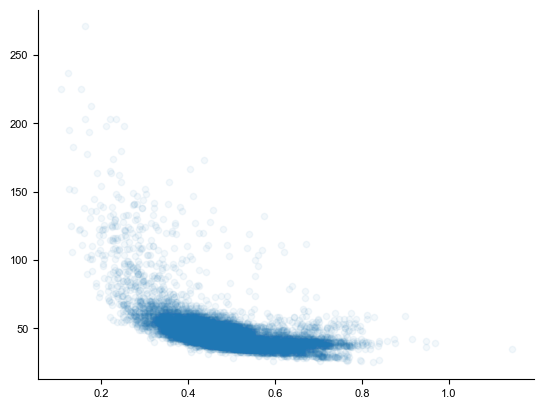

In [64]:
plt.scatter(pv_all, 10/av_all, 20, alpha=0.05)


Text(0.5, 1.0, 'var_pv = 0.00906344, var_av = 0.00165283, cov_pv_av = 0.00260781')

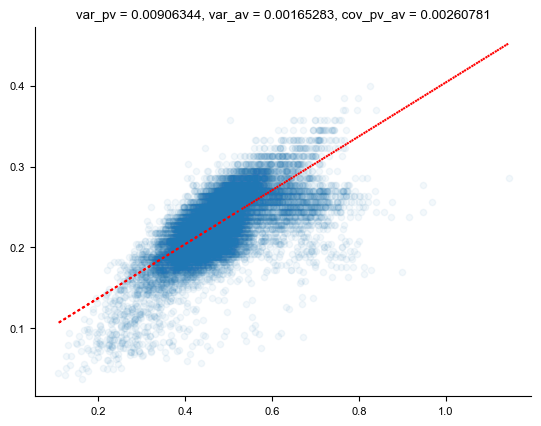

In [65]:
plt.scatter(pv_all, av_all, 20, alpha=0.05)
plt.plot(pv_all, predict_av_from_pv(pv_all, model_av), ':r')
plt.title(f'var_pv = {np.var(pv_all):.8f}, var_av = {np.var(av_all):.8f}, cov_pv_av = {np.cov(pv_all, av_all)[0,1]:.8f}')

With this we compute the linear models. We begin with a single parameter 

## 

## Single parameter model (PV only)

In [66]:
import cbmanifold as cbm
from cbmanifold.linear_model import LinearModel

p0 = np.array([pv0])

lms = []
for i, pvs in tqdm(enumerate(pv_cat)):
    for ori, pv1 in enumerate(pvs):
        rate1 = rate_cat[i][ori]
        lm = cbm.linear_model.generate_linear_model(f'fn_{i}_{ori}', rate1, pv1[:,None], p0, output_type='dict')
        lms.append(lm)


0it [00:00, ?it/s]

In [67]:
n_steps = 7
cols = plt.cm.Greens(np.linspace(0.3, 0.8, n_steps))
prange = np.linspace(300, 660, n_steps)-478.85947
prange = prange*1e-3

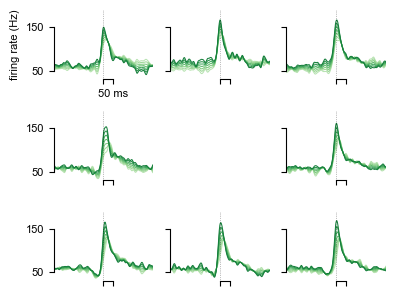

In [27]:
tt = np.arange(-249, 251)

fig, axes = plt.subplots(3, 3, figsize=(4, 3), sharex=False, sharey=True)
axes = axes.flatten()

ori_panels = [5, 2, 1, 0, 3, 6, 7, 8]
for ori in range(8):
    r0 = np.vstack([lm['rate'].ravel() for lm in lms if lm['label'].endswith(f'_{ori}')])
    dr = np.vstack([lm['drate'].ravel() for lm in lms if lm['label'].endswith(f'_{ori}')])

    panel = ori_panels[ori]
    axes[panel].axvline(x=0, ymin=(30-30)/(190-30), ymax=(190-30)/(190-30),
                        linestyle=':', color='black', alpha=0.5, linewidth=0.5)
    for i in range(n_steps):
        axes[panel].plot(tt, r0.mean(axis=0) + prange[i]*dr.mean(axis=0), c=cols[i], linewidth=0.75, zorder=1)

# no axis lines except for the left axis
for (i, ax) in enumerate(axes):
    # Set y-axis limits and only show y-axis line from 50 to 150
    if i != 4:
        ax.set_xlim(-250, 250)
        ax.set_ylim(30, 190)  # Set full y-axis range
        ax.spines['left'].set_bounds(50, 150)  # Only draw y-axis line from 50 to 150
        ax.set_yticks([50, 150])
        ax.set_yticklabels(['', ''])

        ax.spines['bottom'].set_bounds(0, 50)  # Only draw y-axis line from 50 to 150
        ax.set_xticks([0, 50])
        ax.set_xticklabels(['', ''])

# ax = axes[0]
axes[0].set_yticklabels(['50', '150'])
axes[0].set_ylabel('firing rate (Hz)')
axes[0].set_xticklabels(['', '50 ms'])

#remove everything for the 4th panel
axes[4].set_visible(False)

plt.tight_layout()
plt.savefig('average_linear_model_directions.pdf', dpi=600)


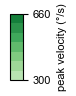

In [28]:
# Create a simple vertical colorbar
fig, ax = plt.subplots(figsize=(2, 1))

# Create a colorbar with the colors used in the previous plot
from matplotlib.colors import ListedColormap

# Assuming cols is the color array used in previous plots
cmap = ListedColormap(cols)
norm = plt.Normalize(vmin=0, vmax=len(cols)-1)

# Create colorbar
cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap),
                   ax=ax, orientation='vertical', aspect=5)
cbar.set_ticks([0, 6])
cbar.set_ticklabels(['300', '660'])
cbar.set_label('peak velocity (°/s)')

# Hide the main axes
ax.set_visible(False)
plt.tight_layout()
plt.savefig('cbar_PV_only.pdf', dpi=600)


In [29]:
lmfn0s = []
for ori in range(8):
    r0 = np.vstack([lm['rate'].ravel() for lm in lms if lm['label'].endswith(f'_{ori}')])
    dr = np.vstack([lm['drate'].ravel() for lm in lms if lm['label'].endswith(f'_{ori}')])
    lm0 = LinearModel('fn_raw', rate=r0, drate=dr, params0=p0)
    lm0.ori = ori
    lm0.n_params = 1
    lmfn0s.append(lm0)

lmfn1s = []
for ori in range(8):
    r0 = lmfn0s[ori].rate
    dr = lmfn0s[ori].drate
    r0_nobase = r0 - (r0[:,:100].mean(axis=-1))[:,None]
    lm1 = LinearModel('fn_nobase', rate=r0_nobase, drate=dr, params0=p0)
    lm1.ori = ori
    lm1.n_params = 1
    lmfn1s.append(lm1)

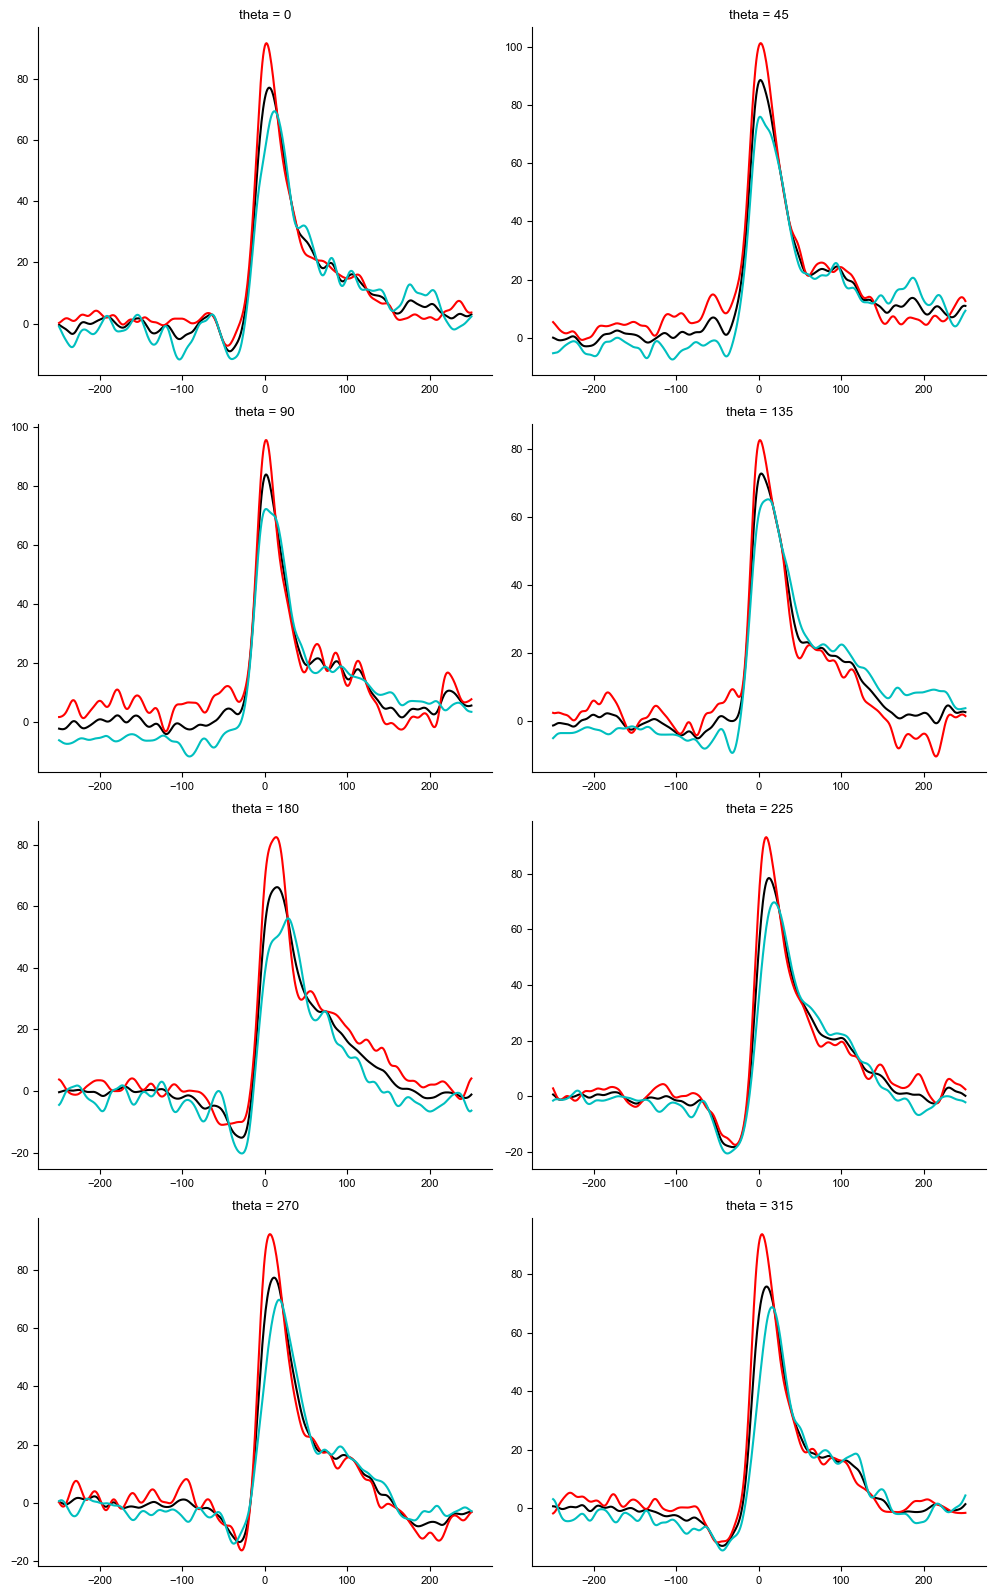

In [40]:
fig, axes = plt.subplots(4, 2, figsize=(10, 16))
axes = axes.flatten()

for ori in range(8):
    lm = lmfn1s[ori]
    r0 = lm.rate
    dr = lm.drate

    axes[ori].plot(tt, r0.mean(axis=0), 'k')
    axes[ori].plot(tt, (r0+dr*.100).mean(axis=0), 'r')
    axes[ori].plot(tt, (r0-dr*.100).mean(axis=0), 'c')
    axes[ori].set_title(f'theta = {45*ori}')

plt.tight_layout()
plt.show()


In [30]:
from cbmanifold.decomposition import pmPCA

# dds = np.empty()

var_exp_cumsums = []

for n in range(8):
    dd, p, v = pmPCA(lmfn1s[n].rate)
    var_explained = dd/np.sum(dd)*1e2;
    var_explained_cumsum = np.cumsum(var_explained);
    for i in range(5):
        print(f'Dimensions: {i+1}, Variance explained: {var_explained_cumsum[i]}')

    nmode = np.where(var_explained_cumsum > 87.5)[0][0]+1
    var_exp_cumsums.append(var_explained_cumsum)
    print(f'Dimensions to be reduced: {nmode}\n')

    # _ = cbm.plot.plot_var_explained(var_explained)

var_exp_cumsums = np.array(var_exp_cumsums)


Dimensions: 1, Variance explained: 61.43552217473173
Dimensions: 2, Variance explained: 70.79977689207193
Dimensions: 3, Variance explained: 77.1621564682111
Dimensions: 4, Variance explained: 81.3169762377338
Dimensions: 5, Variance explained: 84.72299697175897
Dimensions to be reduced: 6

Dimensions: 1, Variance explained: 59.46438492182343
Dimensions: 2, Variance explained: 76.12765764900789
Dimensions: 3, Variance explained: 82.62940096324779
Dimensions: 4, Variance explained: 86.53766859064217
Dimensions: 5, Variance explained: 89.66082834726019
Dimensions to be reduced: 5

Dimensions: 1, Variance explained: 49.54445483617309
Dimensions: 2, Variance explained: 71.87047886857718
Dimensions: 3, Variance explained: 79.4821467034307
Dimensions: 4, Variance explained: 84.48652658667356
Dimensions: 5, Variance explained: 86.73156151983494
Dimensions to be reduced: 6

Dimensions: 1, Variance explained: 57.623610368687
Dimensions: 2, Variance explained: 75.05075582690256
Dimensions: 3, Va

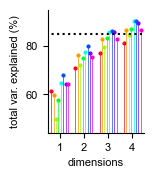

In [313]:
import matplotlib

cmap = matplotlib.colormaps.get_cmap("gist_rainbow")
C_list = cmap( np.linspace(0.0, 1.0, 8) ) # extract 20 colors from cmap

x = np.arange(1,5,1)
fig, ax = plt.subplots(figsize=(1.25, 1.6))

width = 0.1
b = 7
for a in range(8):
    ax.plot(x - width * b + 0.35, var_exp_cumsums[a,:4], 'o', color = C_list[a], markersize=2)
    for k in x:
        ax.plot([k - width * b + 0.35, k - width * b + 0.35], [0, var_exp_cumsums[a,k-1]], '-', color = C_list[a], linewidth=0.5)
    b = b - 1
ax.plot([0, 5], [85, 85], ':k')

ax.set_xticks(x)
ax.set_xlim(0.5, 4.5)
ax.set_ylim(44, 95)
ax.set_xlabel('dimensions')
ax.set_ylabel('total var. explained (%)')

# plt.tight_layout()
plt.savefig('var_exp_all_dirs.pdf',  bbox_inches='tight', dpi=600)


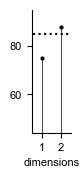

In [265]:
var_exp_cumsums = np.loadtxt('../../data/processed/mf_var_exp_cumsum.csv')

fig, ax = plt.subplots(figsize=(0.5, 1.6))

width = 0.1
b = 7
x = np.arange(1,3,1)


ax.plot(x, var_exp_cumsums[:2], 'o', color = 'k', markersize=2)
for k in x:
    ax.plot([k, k], [0, var_exp_cumsums[k-1]], '-', color = 'k', linewidth=0.5)
ax.plot([0, 5], [85, 85], ':k')

ax.set_xticks(x)
ax.set_xlim(0.5, 2.5)
ax.set_ylim(44, 95)
ax.set_xlabel('dimensions')
# ax.set_ylabel('total var. explained (%)')
ax.set_yticks([60, 80])

# plt.tight_layout()
plt.savefig('var_exp_mf.pdf',  bbox_inches='tight', dpi=600)


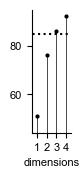

In [268]:
var_exp_cumsums = np.loadtxt('../../data/processed/pc_var_exp_cumsum.csv')

fig, ax = plt.subplots(figsize=(0.5, 1.6))

width = 0.1
b = 7
x = np.arange(1,5,1)


ax.plot(x, var_exp_cumsums[:4], 'o', color = 'k', markersize=2)
for k in x:
    ax.plot([k, k], [0, var_exp_cumsums[k-1]], '-', color = 'k', linewidth=0.5)
ax.plot([0, 5], [85, 85], ':k')

ax.set_xticks(x)
ax.set_xlim(0.5, 4.5)
ax.set_ylim(44, 95)
ax.set_xlabel('dimensions')
# ax.set_ylabel('total var. explained (%)')
ax.set_yticks([60, 80])

# plt.tight_layout()
plt.savefig('var_exp_pc.pdf',  bbox_inches='tight', dpi=600)


In [235]:
var_exp_cumsums

array([ 75.02578754,  87.63450853,  93.14723212,  95.7023277 ,
        97.18809084,  98.0698594 ,  98.66378367,  99.04191721,
        99.30777517,  99.50817347,  99.61912121,  99.70115684,
        99.76687865,  99.80293045,  99.83484555,  99.85891122,
        99.88146888,  99.89911757,  99.91051995,  99.92111937,
        99.92967048,  99.93713513,  99.94339014,  99.94930635,
        99.95365892,  99.95759235,  99.96126799,  99.96457053,
        99.96761648,  99.97019133,  99.97271873,  99.97485101,
        99.9769471 ,  99.97871564,  99.98029825,  99.98175566,
        99.98310144,  99.98437472,  99.98551179,  99.98653982,
        99.9875062 ,  99.98840698,  99.98920001,  99.98994044,
        99.99061371,  99.99121176,  99.99180141,  99.99234816,
        99.99286952,  99.99336317,  99.99382952,  99.99422436,
        99.99461117,  99.99498682,  99.99533918,  99.99568536,
        99.99598498,  99.99625945,  99.99650106,  99.99672441,
        99.99694731,  99.99715884,  99.99734745,  99.99

In [31]:
d0 =     int(dur_from_pv(pv0, model_av))
dplus =  int(dur_from_pv(pv0+0.08, model_av))
dminus = int(dur_from_pv(pv0-0.08, model_av))
print(f'd0 = {d0}, dplus = {dplus}, dminus = {dminus}')


d0 = 43, dplus = 38, dminus = 49


In [32]:
n_steps = 7
cols = plt.cm.Greens(np.linspace(0.3, 0.8, n_steps))
prange = np.linspace(300, 660, n_steps)-478.85947
prange = prange*1e-3

durs = dur_from_pv(pv0+prange, model_av).astype(int)

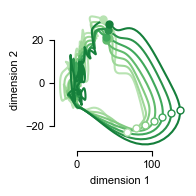

In [33]:
lmr = cbm.decomposition.reduce_dimensionality(lmfn1s[0], 4)
lmr = cbm.utils.flip_sign(lmr, [0, 2]) # flip signs to make the cycles go CCW

fig, ax = plt.subplots(figsize=(2, 2))

for i in range(n_steps):
    ax.plot(lmr.p[0,:] + prange[i]*lmr.dp[0,:],
            lmr.p[1,:] + prange[i]*lmr.dp[1,:],
            c=cols[i], linewidth=1.5, zorder=1)

    ax.plot(lmr.p[0,250] + prange[i]*lmr.dp[0,250],
               lmr.p[1,250] + prange[i]*lmr.dp[1,250],
               'o', markersize=5, markerfacecolor='w', color=cols[i], zorder=3)

#     ax.scatter(lmr.p[0,220] + prange[i]*lmr.dp[0,220],
#                lmr.p[1,220] + prange[i]*lmr.dp[1,220],
#                25, c=cols[i], zorder=1)

    ax.plot(lmr.p[0,250+durs[i]] + prange[i]*lmr.dp[0,250+durs[i]],
               lmr.p[1,250+durs[i]] + prange[i]*lmr.dp[1,250+durs[i]],
               'o', markersize=5, markerfacecolor=cols[i], color=cols[i], zorder=2)

ax.spines['bottom'].set_bounds(0, 100)
ax.set_xticks([0, 100])
ax.spines['left'].set_bounds(-20, 20)
ax.set_yticks([-20, 0, 20])
ax.set_xlabel('dimension 1')
ax.set_ylabel('dimension 2')

plt.tight_layout()
plt.savefig('manifold_deg0_1vs2.pdf')


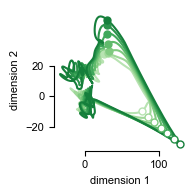

In [34]:
lmr = cbm.decomposition.reduce_dimensionality(lmfn1s[3], 4)
lmr = cbm.utils.flip_sign(lmr, [0, 1, 2]) # flip signs to make the cycles go CCW

fig, ax = plt.subplots(figsize=(2, 2))

for i in range(n_steps):
    ax.plot(lmr.p[0,:] + prange[i]*lmr.dp[0,:],
            lmr.p[1,:] + prange[i]*lmr.dp[1,:],
            c=cols[i], linewidth=1.5, zorder=1)

    ax.plot(lmr.p[0,250] + prange[i]*lmr.dp[0,250],
               lmr.p[1,250] + prange[i]*lmr.dp[1,250],
               'o', markersize=5, markerfacecolor='w', color=cols[i], zorder=3)

#     ax.scatter(lmr.p[0,220] + prange[i]*lmr.dp[0,220],
#                lmr.p[1,220] + prange[i]*lmr.dp[1,220],
#                25, c=cols[i], zorder=1)

    ax.plot(lmr.p[0,250+durs[i]] + prange[i]*lmr.dp[0,250+durs[i]],
               lmr.p[1,250+durs[i]] + prange[i]*lmr.dp[1,250+durs[i]],
               'o', markersize=5, markerfacecolor=cols[i], color=cols[i], zorder=2)

ax.spines['bottom'].set_bounds(0, 100)
ax.set_xticks([0, 100])
ax.spines['left'].set_bounds(-20, 20)
ax.set_yticks([-20, 0, 20])
ax.set_xlabel('dimension 1')
ax.set_ylabel('dimension 2')

plt.tight_layout()
plt.savefig('manifold_deg135_1vs2.pdf')


In [358]:
lmrs = [cbm.decomposition.reduce_dimensionality(lm, 6) for lm in lmfn1s]

In [359]:
# save lmfn0s, lmfn1s, lmr, and model_av as individual pickle files
import pickle
import os

path_model = '../../models'
date_created = '20250529'

save_model = lambda modelname, model: pickle.dump(model, open(os.path.join(path_model, f'{modelname}_{date_created}.pkl'), 'wb'))

save_model('linear_model_FN_PV', lmfn0s)
save_model('linear_model_FN_PV_nobaseline', lmfn1s)
save_model('linear_model_FN_PV_dim_reduced', lmrs)
save_model('model_av_from_pv', model_av)


## Dual parameter model (PV and AV = 10/duration)

In [79]:
import cbmanifold as cbm
from cbmanifold.linear_model import LinearModel

p0 = np.array([pv0,av0])

lms = []
for i, pvs in tqdm(enumerate(pv_cat)):
    for ori, pv1 in enumerate(pvs):
        rate1 = rate_cat[i][ori]
        av1 = 10/dur_cat[i][ori]
        lm = cbm.linear_model.generate_linear_model(f'fn_{i}_{ori}', rate1, np.hstack([pv1[:,None], av1[:,None]]), p0, output_type='dict')
        lms.append(lm)


0it [00:00, ?it/s]

In [102]:
n_steps = 7
# for peak velocity
cols = plt.cm.Reds(np.linspace(0.3, 0.8, n_steps))
prange = np.linspace(300, 660, n_steps)-pv0*1e3


# for average velocity
cols = plt.cm.Blues(np.linspace(0.3, 0.8, n_steps))
prange = np.linspace(175, 225, n_steps)-av0*1e3

prange = prange*1e-3 # deg/sec -> deg/msec

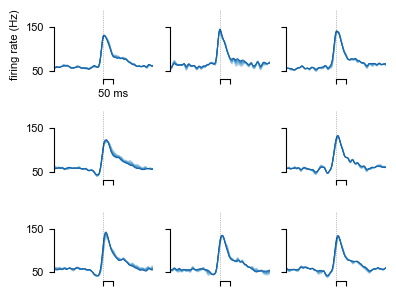

In [ ]:
tt = np.arange(-249, 251)

fig, axes = plt.subplots(3, 3, figsize=(4, 3), sharex=False, sharey=True)
axes = axes.flatten()

ori_panels = [5, 2, 1, 0, 3, 6, 7, 8]
for ori in range(8):
    r0 = np.vstack([lm['rate'].ravel() for lm in lms if lm['label'].endswith(f'_{ori}')])
    dr_all = np.stack([lm['drate'] for lm in lms if lm['label'].endswith(f'_{ori}')],axis=0)
    dr = dr_all[:,1,:] # 0: peak velocity, 1: average velocity

    panel = ori_panels[ori]
    axes[panel].axvline(x=0, ymin=(30-30)/(190-30), ymax=(190-30)/(190-30),
                        linestyle=':', color='black', alpha=0.5, linewidth=0.5)
    for i in range(n_steps):
        axes[panel].plot(tt, r0.mean(axis=0) + prange[i]*dr.mean(axis=0), c=cols[i], linewidth=0.75, zorder=1)

# no axis lines except for the left axis
for (i, ax) in enumerate(axes):
    # Set y-axis limits and only show y-axis line from 50 to 150
    if i != 4:
        ax.set_xlim(-250, 250)
        ax.set_ylim(30, 190)  # Set full y-axis range
        ax.spines['left'].set_bounds(50, 150)  # Only draw y-axis line from 50 to 150
        ax.set_yticks([50, 150])
        ax.set_yticklabels(['', ''])

        ax.spines['bottom'].set_bounds(0, 50)  # Only draw y-axis line from 50 to 150
        ax.set_xticks([0, 50])
        ax.set_xticklabels(['', ''])

# ax = axes[0]
axes[0].set_yticklabels(['50', '150'])
axes[0].set_ylabel('firing rate (Hz)')
axes[0].set_xticklabels(['', '50 ms'])

#remove everything for the 4th panel
axes[4].set_visible(False)

plt.tight_layout()
# plt.savefig('average_linear_model_directions.pdf', dpi=600)


## Dimensionality reduction of dual parameter models for each parameter

In [ ]:
lmfn0s_pv = []
lmfn0s_av = []
for ori in range(8):
    r0 = np.vstack([lm['rate'].ravel() for lm in lms if lm['label'].endswith(f'_{ori}')])
    dr_all = np.stack([lm['drate'] for lm in lms if lm['label'].endswith(f'_{ori}')], axis=0)

    # for peak velocity
    dr = dr_all[:,0,:] # 0: peak velocity, 1: average velocity
    lm0 = LinearModel('fn_pv_raw', rate=r0, drate=dr, params0=np.array([pv0]))
    lm0.ori = ori
    lm0.n_params = 1

    # for average velocity
    dr = dr_all[:,1,:] # 0: peak velocity, 1: average velocity
    lm1 = LinearModel('fn_av_raw', rate=r0, drate=dr, params0=np.array([av0]))
    lm1.ori = ori
    lm1.n_params = 1
    lmfn0s_av.append(lm1)

lmfn1s_pv = []
lmfn1s_av = []
for ori in range(8):
    ##